# HW6: Machine learning

**Due Wednesday April 6, 8pm**

(AY250 2022)

## Galaxy Classification with CNNs

Galaxies appear with different shapes and colors depending on a number of factors, including age, distance, and history of mergers with other galaxies. A crowd-sourced group was [asked to visually classify a set of galaxies from a telescope survey](https://data.galaxyzoo.org/gz_trees/gz_trees.html), resulting in a labelled dataset of 21,785 galaxies across 10 different labels.

You can download it locally:
```bash
curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
```
Or access it on the shared drive on `astro.datahub.berkeley.edu` at `shared/HW_6/galaxies10.h5`

First, load the data:

In [1]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# gpu?
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
    has_gpu = False
else:
    print('Found GPU at: {}'.format(device_name))
    has_gpu = True

# To get the images and labels from file
with h5py.File('galaxies10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

print(f"labels shape: {labels.shape}")
print(f"images shape: {images.shape}")

Found GPU at: /device:GPU:0Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB




2022-04-04 00:17:24.740319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-04 00:17:24.740407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


labels shape: (21785, 10)
images shape: (21785, 69, 69, 3)


In [2]:
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Visualize and inspect

In a single, multi-panel figure visualize one randomly chosen galaxy from each of the 10 classes. Be sure to set the random seed so that your figure will be reproducible. 

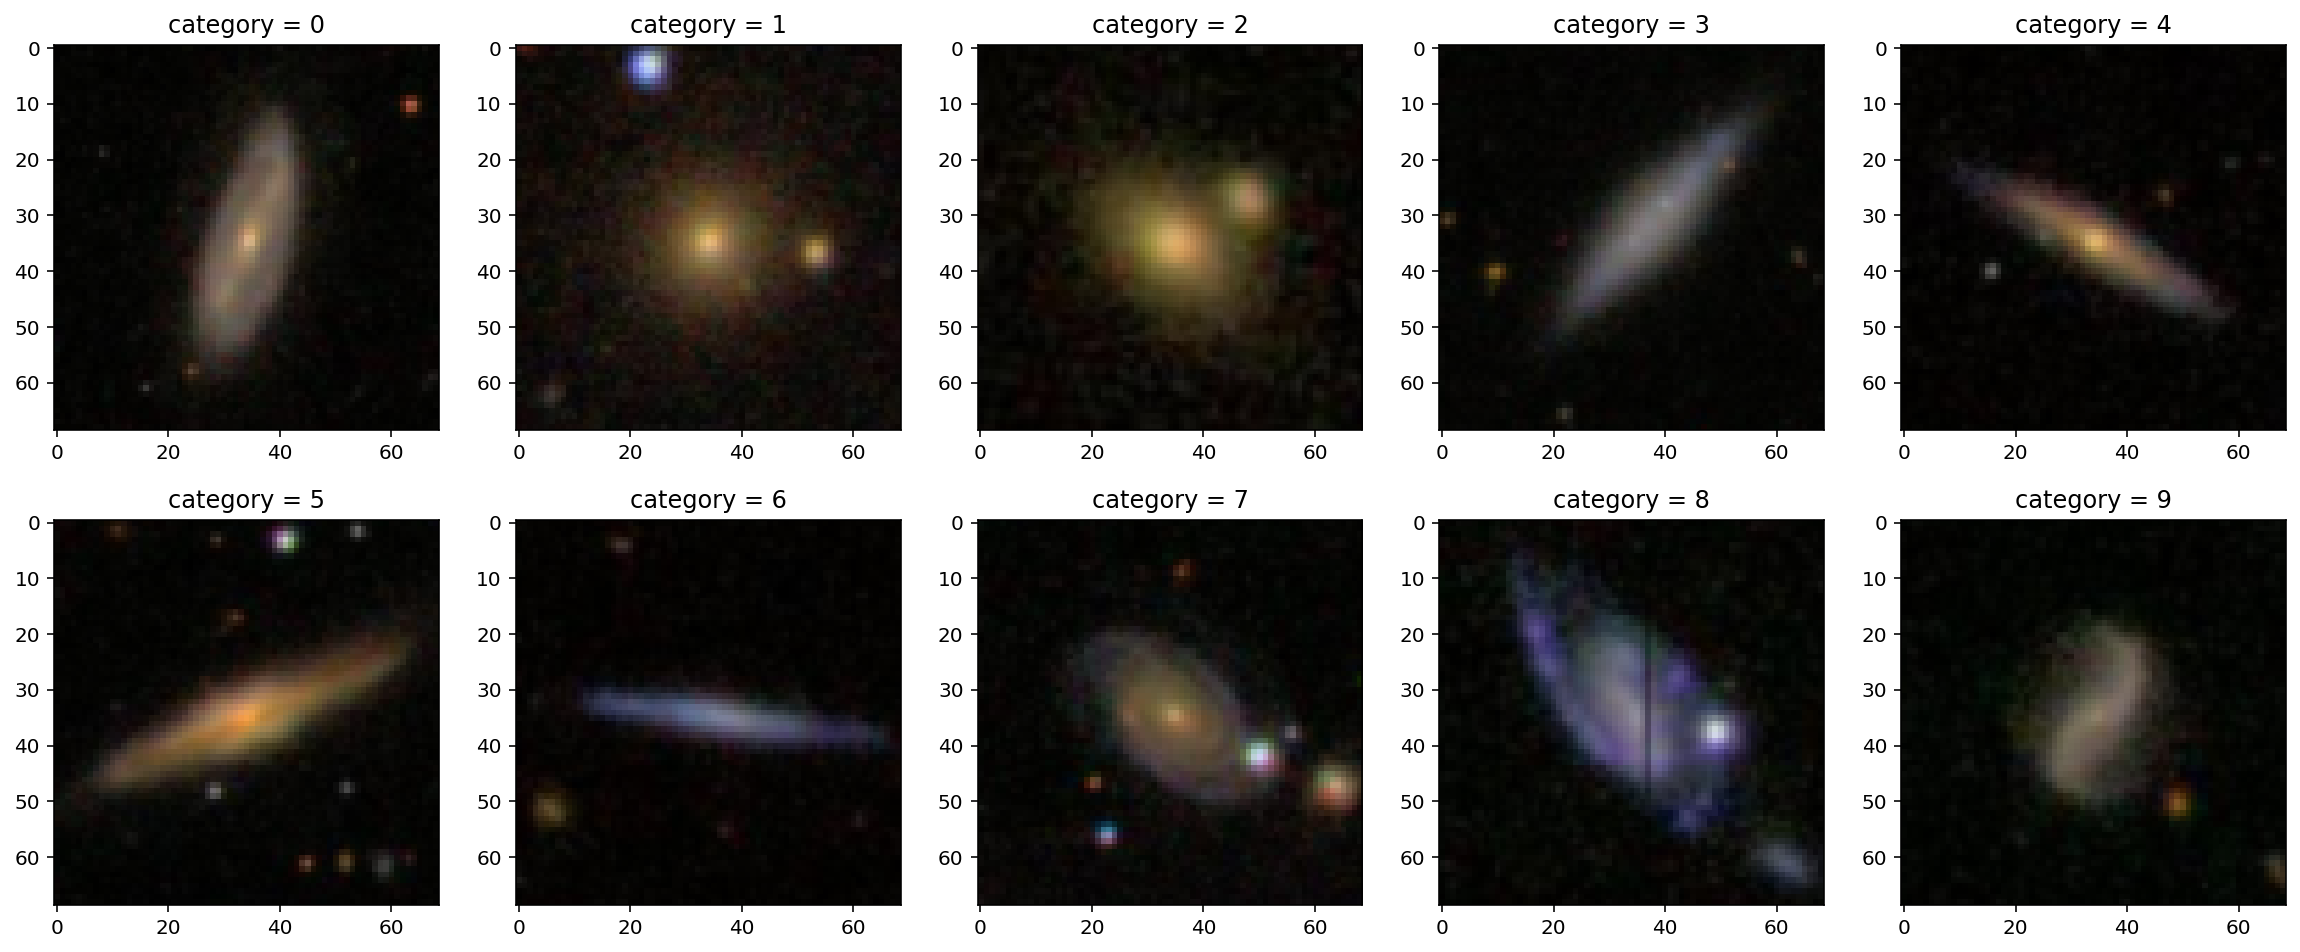

In [3]:
np.random.seed(42)

plt.figure(figsize=(20,8))
for i in range(0, 10):
    idx = np.random.choice(np.where(labels[:,i]==1)[0])
    img = Image.fromarray(images[idx].astype(np.uint8))

    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(f'category = {i}')
plt.show()

Show a histogram of the distribution of galaxies across classes. Comment on any differences you notice with this dataset and the MNIST.

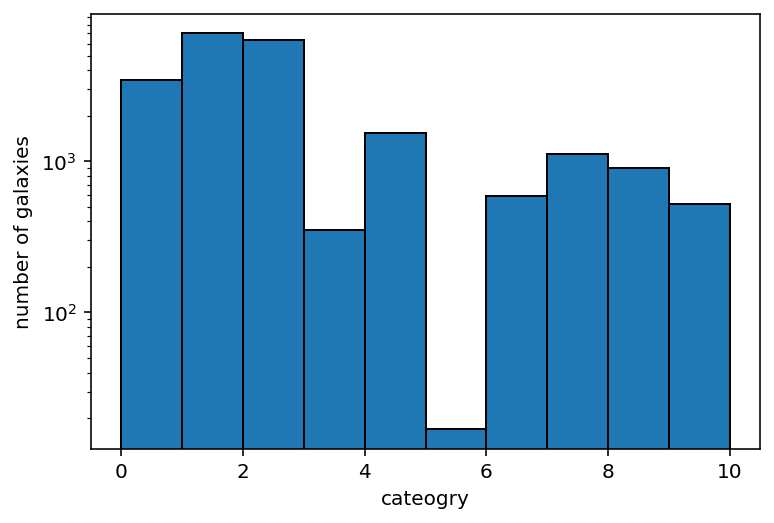

In [4]:
category = np.where(labels==1)[1]
plt.hist(category, bins=np.arange(0,10+1e-9,1), edgecolor='black')
plt.yscale('log')
plt.xlabel('cateogry')
plt.ylabel('number of galaxies')
plt.show()

#### Comment: the class distribution is not balanced. For example, there are far more class 1 and 2 than other classes, and class 5 only has 17 data points. This could be a problem in the training if not handeled well. 

### Prepare for training

First, split the dataset into a train, validation, and test set with a fixed random seed. Then, construct a simple (~few layers) CNN that will accommodate the 69x69x3 images and return a classification. Hint: you will need to modify the networks we built in class to handle the 3d inputs (check out `Conv3D` https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D).

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  

rnd = np.random.RandomState(42)

ind_arr = np.arange(images.shape[0])
rnd.shuffle(ind_arr)

train_ind, tmp = train_test_split(ind_arr, train_size=0.9, random_state=rnd)
valid_ind, test_ind = train_test_split(tmp, train_size=0.5, random_state=rnd)

X_train, y_train = images[train_ind], labels[train_ind]
X_val, y_val = images[valid_ind], labels[valid_ind]
X_test, y_test = images[test_ind], labels[test_ind]

# scale data
X_train /= 255.0
X_val /= 255.0
X_test /= 255.0

print(X_train.shape, X_val.shape, X_test.shape)

(19606, 69, 69, 3) (1089, 69, 69, 3) (1090, 69, 69, 3)


In [6]:
# build model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, Activation, BatchNormalization, Dense, Dropout, Flatten

input_shape = X_train[0].shape

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(10))

model.add(Activation('softmax'))

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

2022-04-04 00:17:29.685889: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-04 00:17:29.685906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Train

Using early stopping and learning rate decay, train the network you built. Use the validation dataset at the end of each epoch for the early stopping. You might decide to do this part on colab for GPU access.

In [7]:
import datetime 
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

logdir = os.path.join("model_output", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_path = f'{logdir}/model.h5'
print(f"Training ... {model_path}")

tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=0,
                 write_graph=True, 
                 write_grads=False, 
                 write_images=False, 
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None, embeddings_data=None)

csv_logger = CSVLogger(f'{logdir}/training.log')

# learning rate decay
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

# early stopping
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

np.random.seed(0)
with tf.device('/gpu:0'):
    model.fit(X_train,
            y=y_train, 
            epochs=20,
            batch_size=64,
            validation_data=(X_val, y_val), 
            callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... model_output/20220404-001729/model.h5
Epoch 1/20


2022-04-04 00:17:30.712344: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-04 00:17:30.897770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


306/307 [============================>.] - ETA: 0s - loss: 1.3446 - accuracy: 0.4521

2022-04-04 00:17:41.314268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.56107, saving model to model_output/20220404-001729/model.h5
307/307 [==============================] - 11s 34ms/step - loss: 1.3444 - accuracy: 0.4524 - val_loss: 1.1032 - val_accuracy: 0.5611 - lr: 0.0010
Epoch 2/20
307/307 [==============================] - ETA: 0s - loss: 1.0445 - accuracy: 0.5877
Epoch 2: val_accuracy improved from 0.56107 to 0.61524, saving model to model_output/20220404-001729/model.h5
307/307 [==============================] - 9s 31ms/step - loss: 1.0445 - accuracy: 0.5877 - val_loss: 1.0004 - val_accuracy: 0.6152 - lr: 0.0010
Epoch 3/20
306/307 [============================>.] - ETA: 0s - loss: 0.8899 - accuracy: 0.6634
Epoch 3: val_accuracy improved from 0.61524 to 0.66942, saving model to model_output/20220404-001729/model.h5
307/307 [==============================] - 9s 30ms/step - loss: 0.8897 - accuracy: 0.6635 - val_loss: 0.8929 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 4/20
307/307 [========================

### Evaluation

Use your trained model and apply it to the test set. How well did you do (total accuracy)? Plot a confusion matrix and comment where the network was most confused.

In [8]:
with tf.device('/gpu:0'):
    pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test,axis=1)
truth_test = np.argmax(y_test, axis=1)

print(f'test accuracy: {np.sum(truth_test==pred_test)/len(truth_test)}')

2022-04-04 00:18:55.766192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


test accuracy: 0.7871559633027523


#### Test accuracy is around 78%, roughly the same as the validation accuracy. 

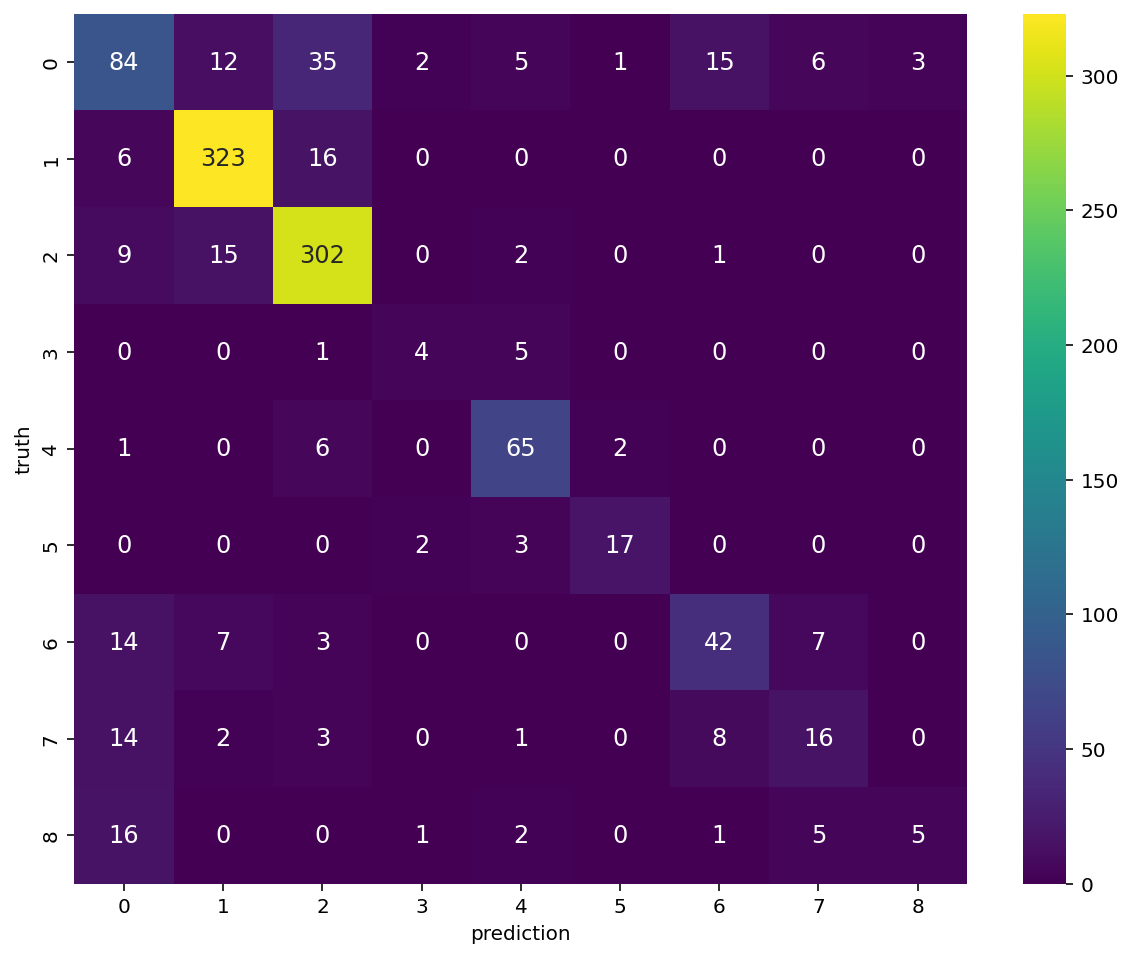

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(truth_test, pred_test)

plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, cmap="viridis", annot=conf_mat, annot_kws={'fontsize': 12}, fmt='.0f')
plt.ylabel('truth')
plt.xlabel('prediction')
plt.show()

#### The network is most confused at predicting classes 0, 8, and 9. Many class 0 samples are wrongly classified as class 2. In additionl, most of class 8 and 9 are also wrongly predicted as other classes. 

### Improve - data augmentation

Now that you have a baseline accuracy, you can work to try to improve the results. Without changing your network architecture, implement a data augmentation strategy, retrain, and then reevaluate. How much improvement did you see?

In [10]:
# augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# creating the data aumentation genreators for both the training images and the training label masks
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=15.,
                     rescale=1.0,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode = 'nearest')

image_datagen = ImageDataGenerator(**data_gen_args)

image_generator = image_datagen.flow(X_train,  y_train, shuffle = True, batch_size=64, seed=42)
validation_generator = image_datagen.flow(X_val,  y_val, shuffle = True, batch_size=64, seed=42)

In [11]:
# build model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, Activation, BatchNormalization, Dense, Dropout, Flatten

input_shape = X_train[0].shape

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(10))

model.add(Activation('softmax'))

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [12]:
import datetime 
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

logdir = os.path.join("augmented_model_output", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

model_path = f'{logdir}/model.h5'
print(f"Training ... {model_path}")

tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=0,
                 write_graph=True, 
                 write_grads=False, 
                 write_images=False, 
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None, embeddings_data=None)

csv_logger = CSVLogger(f'{logdir}/training.log')

# learning rate decay
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

# early stopping
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

np.random.seed(0)
with tf.device('/gpu:0'):
    model.fit(image_generator, 
            epochs=40,
            batch_size=64,
            validation_data=(X_val, y_val), 
            callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... augmented_model_output/20220404-001856/model.h5
Epoch 1/40
  1/307 [..............................] - ETA: 1:29 - loss: 2.2915 - accuracy: 0.1875

2022-04-04 00:18:56.756972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


307/307 [==============================] - ETA: 0s - loss: 1.3384 - accuracy: 0.4501

2022-04-04 00:19:08.015339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.56198, saving model to augmented_model_output/20220404-001856/model.h5
307/307 [==============================] - 12s 37ms/step - loss: 1.3384 - accuracy: 0.4501 - val_loss: 1.0899 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 2/40
306/307 [============================>.] - ETA: 0s - loss: 1.0708 - accuracy: 0.5697
Epoch 2: val_accuracy did not improve from 0.56198
307/307 [==============================] - 11s 35ms/step - loss: 1.0715 - accuracy: 0.5696 - val_loss: 1.0902 - val_accuracy: 0.5436 - lr: 0.0010
Epoch 3/40
306/307 [============================>.] - ETA: 0s - loss: 0.9565 - accuracy: 0.6302
Epoch 3: val_accuracy improved from 0.56198 to 0.67677, saving model to augmented_model_output/20220404-001856/model.h5
307/307 [==============================] - 11s 34ms/step - loss: 0.9558 - accuracy: 0.6306 - val_loss: 0.8542 - val_accuracy: 0.6768 - lr: 0.0010
Epoch 4/40
306/307 [============================>.] - ETA: 0s - loss: 0.8549 - ac

2022-04-04 00:22:32.660323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


test accuracy: 0.8394495412844036


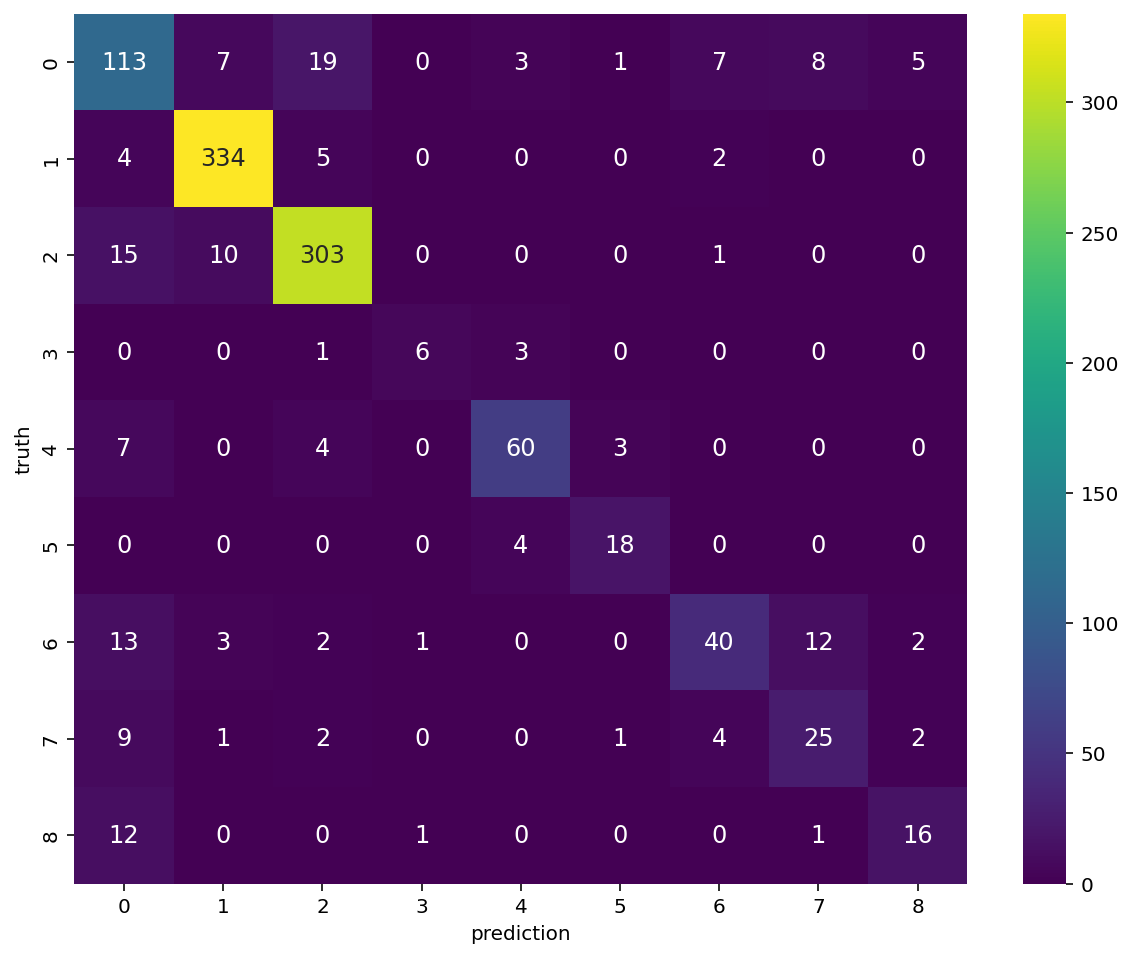

In [13]:
with tf.device('/gpu:0'):
    pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test,axis=1)
truth_test = np.argmax(y_test, axis=1)

print(f'test accuracy: {np.sum(truth_test==pred_test)/len(truth_test)}')

conf_mat = confusion_matrix(truth_test, pred_test)

plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, cmap="viridis", annot=conf_mat, annot_kws={'fontsize': 12}, fmt='.0f')
plt.ylabel('truth')
plt.xlabel('prediction')
plt.show()

#### The test accuracy improved by roughly 6%, reaching 83%. The confusion matrix is also more diagonal than before, especially for classes 8 and 9. 

### Improve - network

Change/embellish your original network to try to improve the results (try adding layers, changing the initialization of the kernel weights, changing the activation, adding dropout). You can use an automl trainer if you'd like or try different approaches by hand. Retrain and then reevaluate. Explain what you did but only show us the best model and its evaluation.

In [25]:
# augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# creating the data aumentation genreators for both the training images and the training label masks
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=15.,
                     rescale=1.0,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode = 'nearest')

image_datagen = ImageDataGenerator(**data_gen_args)

image_generator = image_datagen.flow(X_train,  y_train, shuffle = True, batch_size=64, seed=42)
validation_generator = image_datagen.flow(X_val,  y_val, shuffle = True, batch_size=64, seed=42)

In [41]:
# build model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, Activation, BatchNormalization, Dense, Dropout, Flatten

input_shape = X_train[0].shape

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='random_normal', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='random_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_initializer='random_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Flatten())

# model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10))

model.add(Activation('softmax'))

# model.summary()

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [42]:
import datetime 
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

logdir = os.path.join("augmented_model_output", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

model_path = f'{logdir}/model.h5'
print(f"Training ... {model_path}")

tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=0,
                 write_graph=True, 
                 write_grads=False, 
                 write_images=False, 
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None, embeddings_data=None)

csv_logger = CSVLogger(f'{logdir}/training.log')

# learning rate decay
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=3, min_lr=1e-6, verbose=1, cooldown=0)

# early stopping
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=5, \
                                             verbose=1, mode='auto')

model_check = ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

np.random.seed(0)
with tf.device('/gpu:0'):
    model.fit(image_generator, 
            epochs=40,
            batch_size=64,
            validation_data=(X_val, y_val), 
            callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... augmented_model_output/20220404-014458/model.h5
Epoch 1/40


2022-04-04 01:44:58.601577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


307/307 [==============================] - ETA: 0s - loss: 1.2504 - accuracy: 0.5012

2022-04-04 01:45:25.755795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.53444, saving model to augmented_model_output/20220404-014458/model.h5
307/307 [==============================] - 28s 90ms/step - loss: 1.2504 - accuracy: 0.5012 - val_loss: 1.5101 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 2/40
307/307 [==============================] - ETA: 0s - loss: 0.9208 - accuracy: 0.6515
Epoch 2: val_accuracy improved from 0.53444 to 0.68136, saving model to augmented_model_output/20220404-014458/model.h5
307/307 [==============================] - 28s 90ms/step - loss: 0.9208 - accuracy: 0.6515 - val_loss: 0.8966 - val_accuracy: 0.6814 - lr: 0.0010
Epoch 3/40
307/307 [==============================] - ETA: 0s - loss: 0.7793 - accuracy: 0.7068
Epoch 3: val_accuracy did not improve from 0.68136
307/307 [==============================] - 26s 85ms/step - loss: 0.7793 - accuracy: 0.7068 - val_loss: 0.8861 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 4/40
307/307 [==============================] - ETA: 0s - loss: 0.7200 - ac

2022-04-04 03:13:25.098658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


test accuracy: 0.8660550458715597


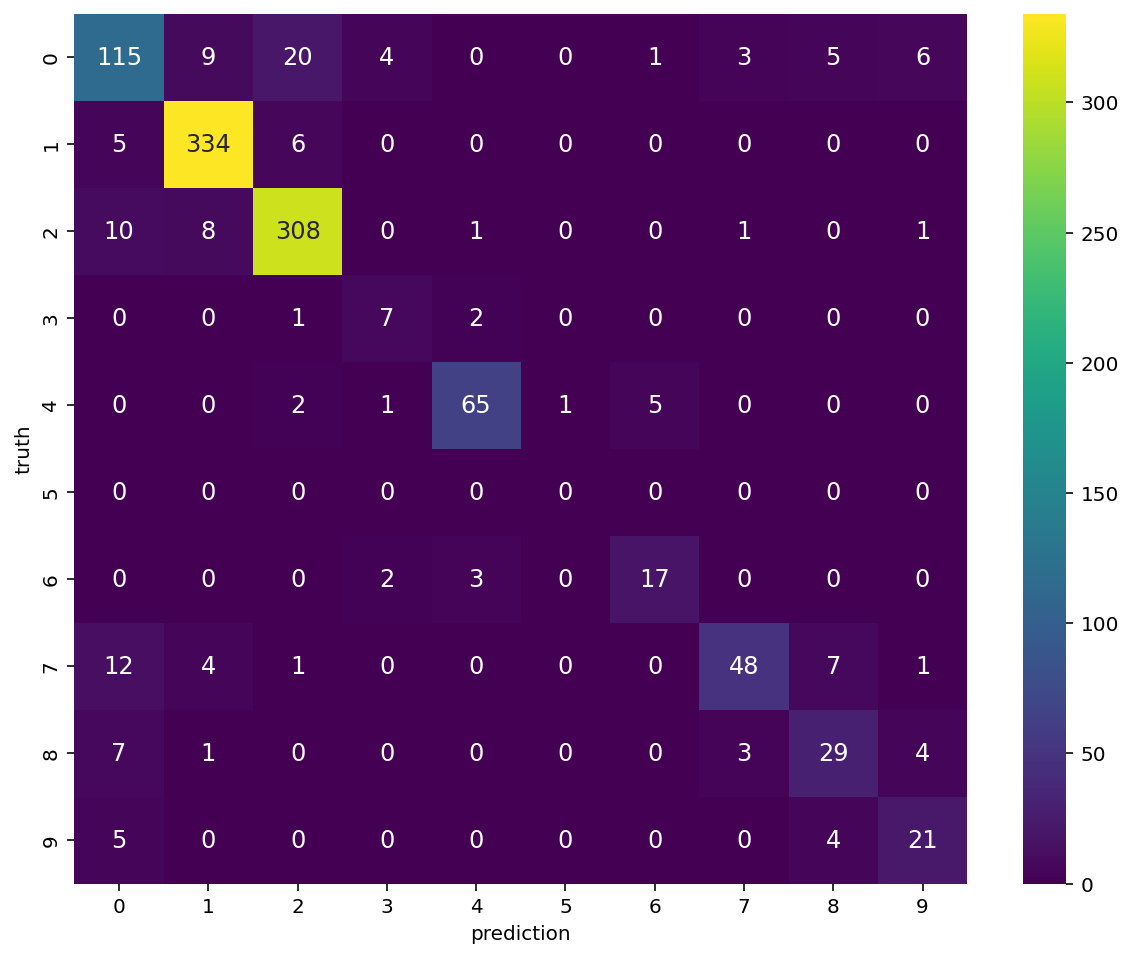

In [43]:
with tf.device('/gpu:0'):
    pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test,axis=1)
truth_test = np.argmax(y_test, axis=1)

print(f'test accuracy: {np.sum(truth_test==pred_test)/len(truth_test)}')

conf_mat = confusion_matrix(truth_test, pred_test)

plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, cmap="viridis", annot=conf_mat, annot_kws={'fontsize': 12}, fmt='.0f')
plt.ylabel('truth')
plt.xlabel('prediction')
plt.show()

#### Applied modifications are: 1) batch normalization 2) drop out with probability of 10% 3) adding more neurons and layers 4) changing the weight prior from uniform to gaussian. After the modifications, the test accuracy improves to 87%. 

## Autoencoders

A form of non-parametric representation learning with neutral nets, where the architecture of the network is used to reduce the dimensionality of the data. First, go through (and execute) the following codeblocks and make sure you understand what they are doing to build and use an autoencoder.

As the name suggests, autoencoders uses the data itself to learn the best way to represent it in a compact way--it's a form of semantic compression. This is a family of self- (or un-) supervised modeling.

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png">
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In practice, we take an input X (which may be a 1-d vector, 2-d image, ...) and try to squeeze it down to a smaller number of values in the "bottleneck" layer and then uncompress back to it's original shape and form. The loss function that we construct will be the way in which the network learns on each backprop through the data.

Let's look at a autoencoder which uses convnets to restruct the fashion dataset.

In [44]:
import datetime, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow 
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, \
                                    Activation, BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K
import tensorflow as tf

# Print keras version
print(tensorflow.keras.__version__)

from tensorflow.keras.utils import to_categorical

fashion_mnist = tf.keras.datasets.fashion_mnist

nb_classes = 10
batch_size = 128
bottleneck_size = 64

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)
input_shape
input_img = Input(shape = (28, 28, 1))

2.8.0


Make a simple autoencoder

In [47]:
np.random.seed(0)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(128)(bottleneck)
x = Reshape((4, 4, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# add with tf.device('/gpu:0'): if on GPU
with tf.device('/gpu:0'):
    autoencoder = Model(input_img, decoded)


logdir = os.path.join(
    "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)

tensorboard_callback = \
    tensorflow.keras.callbacks.TensorBoard(logdir,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_grads=False,
                                           write_images=False,
                                           embeddings_freq=0,
                                           embeddings_layer_names=None,
                                           embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train, x_train,
                                    batch_size=batch_size, epochs=10,
                                    verbose=1, shuffle=False,
                                    validation_data=(x_test, x_test),
                                    callbacks=[tensorboard_callback, model_check])

Training ... nn_results/ay250_autoencoder_nn_2022-04-04T10:18.h5
Epoch 1/10


2022-04-04 03:18:20.778890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.0414

2022-04-04 03:18:34.470559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.02516, saving model to nn_results/ay250_autoencoder_nn_2022-04-04T10:18.h5
469/469 [==============================] - 15s 31ms/step - loss: 0.0414 - val_loss: 0.0252
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 0.0223
Epoch 2: val_loss improved from 0.02516 to 0.02044, saving model to nn_results/ay250_autoencoder_nn_2022-04-04T10:18.h5
469/469 [==============================] - 13s 28ms/step - loss: 0.0223 - val_loss: 0.0204
Epoch 3/10
467/469 [============================>.] - ETA: 0s - loss: 0.0198
Epoch 3: val_loss improved from 0.02044 to 0.01875, saving model to nn_results/ay250_autoencoder_nn_2022-04-04T10:18.h5
469/469 [==============================] - 13s 28ms/step - loss: 0.0198 - val_loss: 0.0188
Epoch 4/10
468/469 [============================>.] - ETA: 0s - loss: 0.0184
Epoch 4: val_loss improved from 0.01875 to 0.01771, saving model to nn_results/ay250_autoencoder_nn_2022-04-04T10:18.h5
469/469 [==========

In [48]:
from tensorflow.keras.models import load_model
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
latest_model_file = latest_model_file[0]
print(f"Using {latest_model_file}")
autoencoder = load_model(latest_model_file)

Using nn_results/ay250_autoencoder_nn_2022-04-04T10:18.h5


2022-04-04 10:49:16.877843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


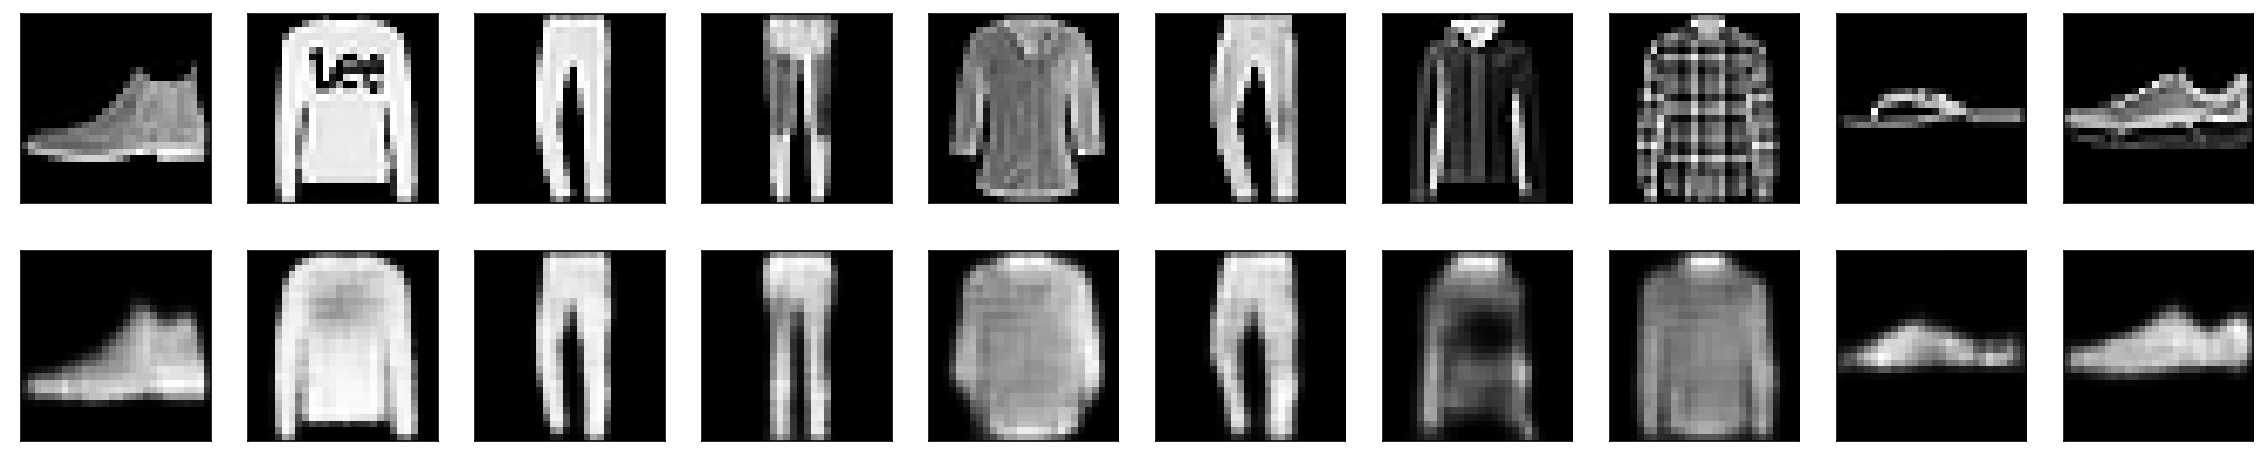

In [49]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Classify using Random Forest

Using the autoencoder model above, create a random forest model to predict the classes of the images using the 64-parameter bottleneck layer. What accuracy do you get? How does it compare with the accuracy we got on the `convnet` model before?

In [51]:
model_encoder = Model(input_img, bottleneck)

In [65]:
train_encoded = model_encoder.predict(x_train)
test_encoded = model_encoder.predict(x_test)

In [68]:
from sklearn.ensemble import RandomForestClassifier
np.random.rand(0)

# instantiate classifier object
classifier = RandomForestClassifier(n_estimators=100)

# fit the classification model on training set
classifier.fit(train_encoded, y_train)

# make predictions for testing set
pred_rf = classifier.predict(test_encoded) 

print(f'test accuracy: {np.sum(y_test==pred_rf)/len(y_test)}')

test accuracy: 0.8579


#### The accuracy (~86%) is a little bit worse but already comparable to the vanilla CNN accuracy (~88%). 

### Bottleneck size variation

Experiment with trying a different sized layer (e.g., size 4, 16, 32) and repeat step a) above. Do you see any trends with bottleneck size?

In [77]:
def AE(bottleneck_size):

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Flatten()(x) # 128
    
    bottleneck = Dense(bottleneck_size, name="bottleneck")(x) # bottleneck_size

    x = Dense(128)(bottleneck) # 128
    x = Reshape((4, 4, 8))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    model_encoder = Model(input_img, bottleneck)

    return autoencoder, model_encoder

In [83]:
def RF(train_encoded, test_encoded):
    np.random.rand(0)

    # instantiate classifier object
    classifier = RandomForestClassifier(n_estimators=100)

    # fit the classification model on training set
    classifier.fit(train_encoded, y_train)

    # make predictions for testing set
    pred_rf = classifier.predict(test_encoded) 

    print(f'test accuracy: {np.sum(y_test==pred_rf)/len(y_test)}')
    
    return np.sum(y_test==pred_rf)/len(y_test)

In [84]:
sizes = [4, 16, 32, 64]
accuracies = []

np.random.seed(0)
for size in sizes:
    with tf.device('/gpu:0'):
        autoencoder, model_encoder = AE(size)
        autoencoder_train = autoencoder.fit(x_train, x_train,
                                        batch_size=batch_size, epochs=10,
                                        verbose=1, shuffle=False,
                                        validation_data=(x_test, x_test))

    train_encoded = model_encoder.predict(x_train)
    test_encoded = model_encoder.predict(x_test)

    accuracies.append(RF(train_encoded, test_encoded))

Epoch 1/10


2022-04-04 12:57:43.365155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.0466

2022-04-04 12:57:58.050486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 16s 33ms/step - loss: 0.0466 - val_loss: 0.0364
Epoch 2/10
469/469 [==============================] - 16s 33ms/step - loss: 0.0317 - val_loss: 0.0296
Epoch 3/10
469/469 [==============================] - 14s 30ms/step - loss: 0.0290 - val_loss: 0.0279
Epoch 4/10
469/469 [==============================] - 14s 30ms/step - loss: 0.0277 - val_loss: 0.0269
Epoch 5/10
469/469 [==============================] - 14s 30ms/step - loss: 0.0269 - val_loss: 0.0262
Epoch 6/10
469/469 [==============================] - 14s 31ms/step - loss: 0.0263 - val_loss: 0.0258
Epoch 7/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0259 - val_loss: 0.0255
Epoch 8/10
469/469 [==============================] - 13s 29ms/step - loss: 0.0255 - val_loss: 0.0251
Epoch 9/10
469/469 [==============================] - 14s 30ms/step - loss: 0.0253 - val_loss: 0.0249
Epoch 10/10
469/469 [==============================] - 13s 29ms/step - loss: 0.0250 - val_los

2022-04-04 13:00:06.119968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:00:08.299415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


test accuracy: 0.7453
Epoch 1/10


2022-04-04 13:00:19.830783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.0399

2022-04-04 13:00:32.685153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 14s 29ms/step - loss: 0.0399 - val_loss: 0.0282
Epoch 2/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0252 - val_loss: 0.0232
Epoch 3/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0227 - val_loss: 0.0216
Epoch 4/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0212 - val_loss: 0.0204
Epoch 5/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0203 - val_loss: 0.0195
Epoch 6/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0196 - val_loss: 0.0189
Epoch 7/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0191 - val_loss: 0.0185
Epoch 8/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0187 - val_loss: 0.0181
Epoch 9/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0183 - val_loss: 0.0178
Epoch 10/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0180 - val_los

2022-04-04 13:02:31.889366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:02:34.163698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


test accuracy: 0.8301
Epoch 1/10


2022-04-04 13:02:55.272546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.0366

2022-04-04 13:03:08.416375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 14s 29ms/step - loss: 0.0366 - val_loss: 0.0263
Epoch 2/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0231 - val_loss: 0.0213
Epoch 3/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0207 - val_loss: 0.0197
Epoch 4/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0194 - val_loss: 0.0186
Epoch 5/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0185 - val_loss: 0.0179
Epoch 6/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0179 - val_loss: 0.0173
Epoch 7/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0173 - val_loss: 0.0168
Epoch 8/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0169 - val_loss: 0.0164
Epoch 9/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0165 - val_loss: 0.0160
Epoch 10/10
469/469 [==============================] - 13s 27ms/step - loss: 0.0162 - val_los

2022-04-04 13:05:06.783752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:05:08.958961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


test accuracy: 0.8459
Epoch 1/10


2022-04-04 13:05:35.486638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.0336

2022-04-04 13:05:48.313945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 14s 29ms/step - loss: 0.0336 - val_loss: 0.0244
Epoch 2/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0215 - val_loss: 0.0199
Epoch 3/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0193 - val_loss: 0.0183
Epoch 4/10
469/469 [==============================] - 13s 27ms/step - loss: 0.0180 - val_loss: 0.0174
Epoch 5/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0172 - val_loss: 0.0166
Epoch 6/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0165 - val_loss: 0.0160
Epoch 7/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0160 - val_loss: 0.0155
Epoch 8/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 9/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 10/10
469/469 [==============================] - 13s 28ms/step - loss: 0.0148 - val_los

2022-04-04 13:07:46.584235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 13:07:48.851612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


test accuracy: 0.8551


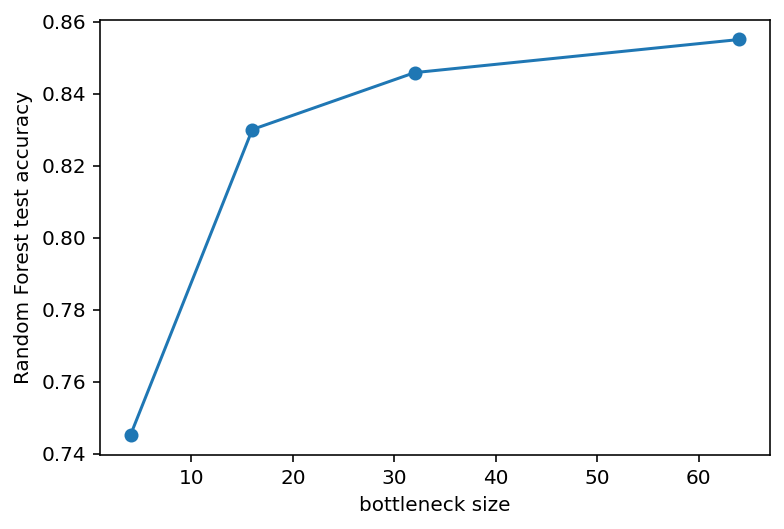

In [87]:
plt.figure()
plt.plot(sizes, accuracies, 'o-')
plt.xlabel('bottleneck size')
plt.ylabel('Random Forest test accuracy')
plt.show()

#### With increasing bottleneck size, the test accuracy of random forest increases, but it gradually reaches a plateau at larger bottleneck sizes. 